# RECOMMENDATION SYSTEM FOR MOVIES

# 1. Business Understanding

## 1.1 Business Overview
We've all been there, scrolling through a endless list of movies, unable to decide what to watch. For streaming giants like Netflix and ShowMax, solving this "scroll fatigue" is key to keeping users happy and subscribed. Their secret weapon? The recommendation system. This is a smart tool that suggests new titles based on your past ratings and the preferences of viewers like you.

This project taps into that same idea. Using the public MovieLens dataset, we'll develop a model that learns user preferences to predict which films they'll enjoy most. The final output will be a curated list of top 5 movie recommendations for each user, making their viewing experience more personal and enjoyable while boosting platform engagement.

## 1.2 Problem Statement
Endless scrolling is the enemy of enjoyment. When users can't decide what to watch, their engagement drops and streaming platforms face the risk of lower customer retention.

Our challenge is to transform this experience. Instead of presenting users with an overwhelming catalog, we need to provide them with a personalized shortlist. This project focuses on building a recommendation engine that does exactly that, predicting user preferences to deliver a top-five list of tailored suggestions, making discovery effortless and viewing more satisfying.

## 1.3 Business Objectives

### Main Objective:
To build a recommendation model that provides personalized recommendations to users based on their previous ratings and those of similar users.

### Specific Objectives:
1. To explore and preprocess the MovieLens dataset to understand user–movie interaction patterns.

2. To implement a collaborative filtering model that predicts movie ratings based on user or item similarity.

3. To evaluate the performance of the recommendation model using appropriate metrics such as RMSE or MAE.

4. To demonstrate how the recommendation system can be applied in a streaming platform to improve user experience and retention.

## 1.4 Research Questions
1. What patterns can be identified in the MovieLens dataset regarding user–movie interactions?

2. How can collaborative filtering be used to predict user ratings for movies they haven’t seen?

3. How accurately does the model predict user ratings when evaluated using RMSE or MAE metrics?

4. How can implementing a recommendation system improve user satisfaction and retention for a streaming service?

## 1.5 Success Criteria
- Achieve RMSE ≤ 0.90 and MAE ≤ 0.70 on test data.
- Generate meaningful, personalized recommendations.

# 2. Data Understanding
We are using the **MovieLens Small Dataset**, which contains:
- 100,000 movie ratings
- 600+ users
- 9,000+ unique movies

The data includes user IDs, movie IDs, ratings, and movie metadata (titles, genres, tags).

 We have several libraries and tools that are going to be used such as advanced CF algorithims (SVD).

Dataset, Reader, SVD, train_test_split, accuracy, GridSearchCV are going to be used for building and evaluating the matrix factorization component.

TF-IDF and cosine_similarity, will be used to build the Content-Based Filtering component based on movie genres.Lastly,the final model will be serialized for deployment.

# 3. Data Preparation

## 3.1 Importing Liblaries
Importing the neccessary liblaries that will be used for this project.

In [1]:
#Import necessary libraries
! pip install scikit-surprise
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import pickle
from collections import Counter

### 3.2 Loading Data
The ratings.csv and movies.csv files are loaded into Pandas DataFrames.

Shape Inspection: The size of the raw datasets is printed, confirming we are starting with 100,836 ratings and 9,742 movies.

Merging: The ratings data is merged with the necessary title and genres information from the movies data using movieId as the common key. This creates a single DataFrame (ratings_merged) containing all user-item-rating details along with the movie's descriptive features.
 
Preview: The first 10 rows of the merged data are displayed for a quick verification of the merge operation.

In [2]:
#Load Csv files
ratings=pd.read_csv('ratings.csv')
movies=pd.read_csv('movies.csv')
print('Ratings:', ratings.shape)
print('Movies:', movies.shape)
#Merging ratings with Movies
ratings_merged= ratings.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')
ratings_merged.head(10)

Ratings: (100836, 4)
Movies: (9742, 3)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [3]:
# Checking for missing values
ratings_merged.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

There are no any missing values.

In [4]:
# Checking for duplicates
ratings_merged.duplicated().sum()

0

No duplicates.

# 4. Exploratory Data Analysis
**Dataset Size:**

Users: 610 unique users.

Items (Movies): 9,724 unique movies. 

Note: The user-entered code accidentally printed the user count for items, but the movieId unique count is 9,724 based on the movies.csv file structure.

Interactions: 100,836 total ratings.

**User Activity (Interactions per User):** 

The average user has provided 165.7 ratings, which is quite high.

Min: 20 ratings (Confirming the MovieLens condition that all included users have rated at least 20 movies).

Max: 7,376 ratings (Indicating a few highly active "super-users").

**Rating Distribution:** 

The ratings are centered around the high end, with a median and mean rating of 4.0.Mean Rating: 3.501 (Out of 5.0)Std Dev: 1.043These statistics confirm the data is from a relatively small but highly active group of users, and ratings are generally positive.

In [5]:
#Number of Users,Items and interactions
n_users= ratings['userId'].nunique()
n_items= ratings['movieId'].nunique()
print(f'Users: {n_users}, Items: {n_users}, Interactions: {len(ratings)}')
#Count Interactions per user
user_counts= ratings.groupby('userId').size().describe()
print(user_counts)
# ratings distribution
ratings['rating'].describe()

Users: 610, Items: 610, Interactions: 100836
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

**data set overview**

Here, the following is computed about the dataset:

- The total number of ratings in the dataset.

- The number of unique movies that have been rated.

- The number of unique users who have provided ratings.


In [6]:
n_ratings = len(ratings)
n_movies = movies['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f'number of ratings: {n_ratings}')
print(f'number of movies: {n_movies}')
print(f'number of users: {n_users}')

number of ratings: 100836
number of movies: 9742
number of users: 610


As part of the dataset overview, we also plot a distribution of User Ratings and Movie Ratings. 

Plotting the distribution of user ratings will help identify whether it's most users contributing a few ratings or if it's some users rating a significant number of movies.

Plotting movie ratings distribution will help identify whether it's a small number of movies receiving the majority of ratings or if the ratings are evenly distributed.

C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


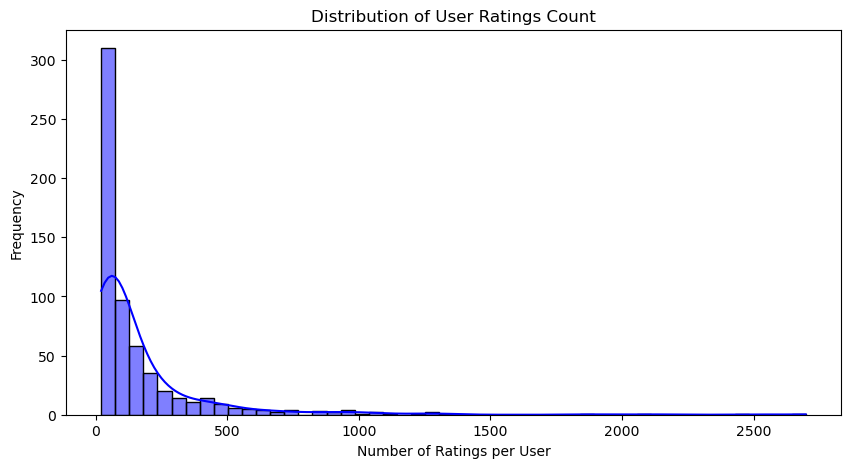

In [7]:
# Compute the number of ratings
user_rating_counts = ratings['userId'].value_counts()

plt.figure(figsize = (10, 5))
sns.histplot(user_rating_counts, bins = 50, kde = True, color = 'blue')
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.title("Distribution of User Ratings Count")
plt.show()

C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


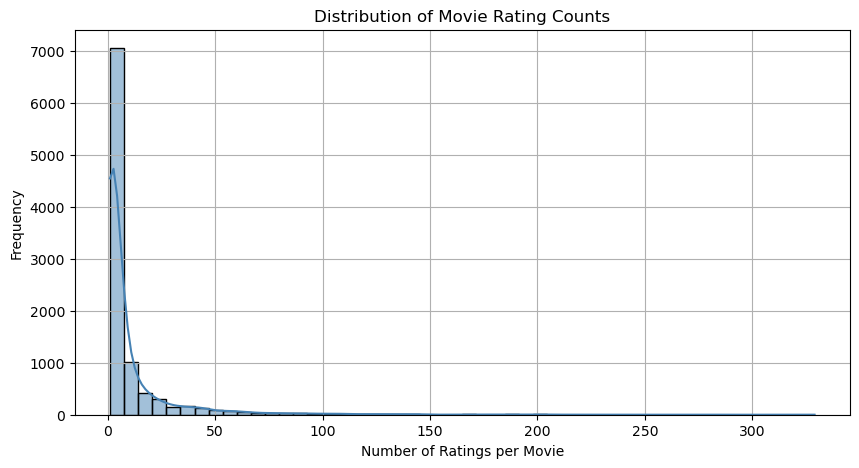

In [8]:
# Compute ratings per movie
movie_rating_counts = ratings['movieId'].value_counts()

plt.figure(figsize = (10, 5))
sns.histplot(movie_rating_counts, bins = 50, kde = True, color = 'steelblue')
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Rating Counts")
plt.grid(True)

plt.show()

Plotting a Ratings Distribution visualization will also be helpful in understanding whether users tend to give positive, neutral or negative ratings.

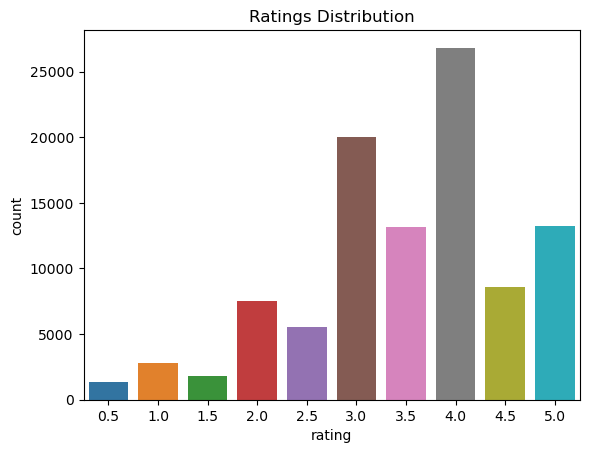

In [9]:
sns.countplot(x = 'rating', data = ratings)
plt.title('Ratings Distribution')
plt.show()

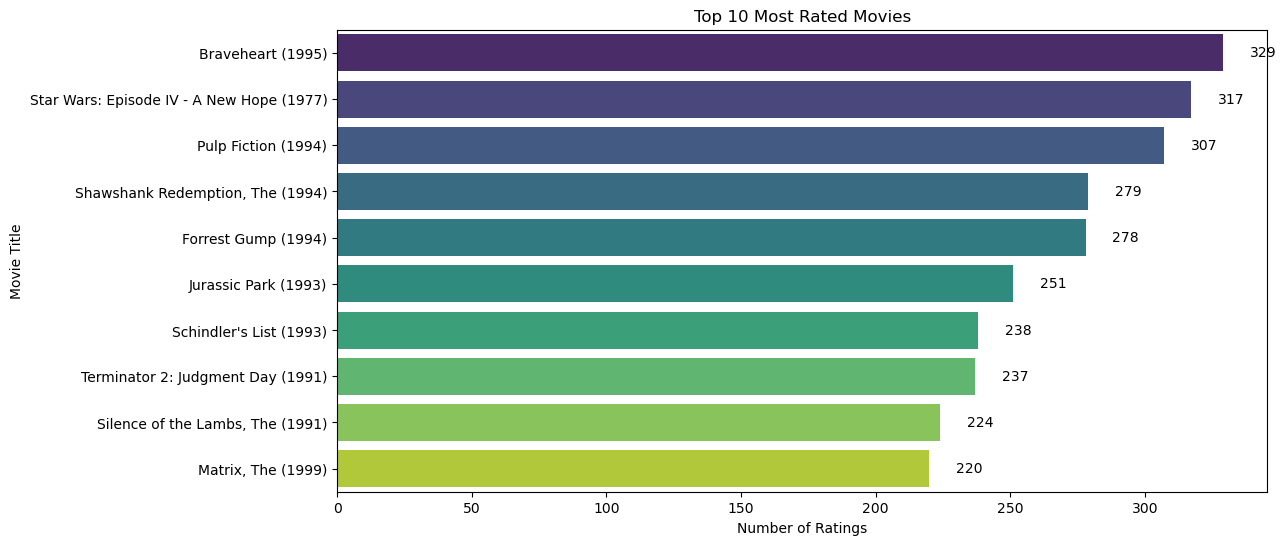

In [14]:
# Get top 10 most rated movies
top_movies = ratings['movieId'].value_counts().head(10).index
top_movies_df = movies[movies['movieId'].isin(top_movies)].copy()
top_movies_df['num_ratings'] = ratings[ratings['movieId'].isin(top_movies)]['movieId'].value_counts().values

# Sort by number of ratings (descending)
top_movies_df = top_movies_df.sort_values('num_ratings', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='num_ratings', y='title', data=top_movies_df, palette='viridis')

for i, v in enumerate(top_movies_df['num_ratings']):
    ax.text(v + 10, i, str(v), color='black', va='center')

plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Rated Movies")
plt.show()

In [15]:
# check movie genres
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# Count occurrences of each genre across all movies and print unique genres
genre_counts = Counter([g for genre in movies['genres'] for g in genre])
print(len(genre_counts))

genre_counts

35


Counter({'r': 15892,
         'a': 13643,
         'e': 13084,
         '|': 12342,
         'm': 12050,
         'o': 10308,
         'i': 9309,
         'n': 8027,
         'y': 6121,
         'd': 5717,
         't': 5695,
         'C': 5619,
         'c': 5178,
         'l': 4907,
         'D': 4801,
         'A': 3860,
         'h': 2558,
         'u': 2037,
         's': 1921,
         'T': 1894,
         'F': 1846,
         'R': 1596,
         'v': 1263,
         '-': 1067,
         'M': 1065,
         'S': 980,
         'H': 978,
         'W': 549,
         'I': 158,
         'X': 158,
         'N': 87,
         ' ': 68,
         '(': 34,
         'g': 34,
         ')': 34})

In [17]:
genre_counts_df = pd.DataFrame([genre_counts]).T.reset_index()
genre_counts_df.columns = ['genre', 'count']
genre_counts_df

,genre,count
0,A,3860
1,d,5717
2,v,1263
3,e,13084
4,n,8027
5,t,5695
6,u,2037
7,r,15892
8,|,12342
9,i,9309


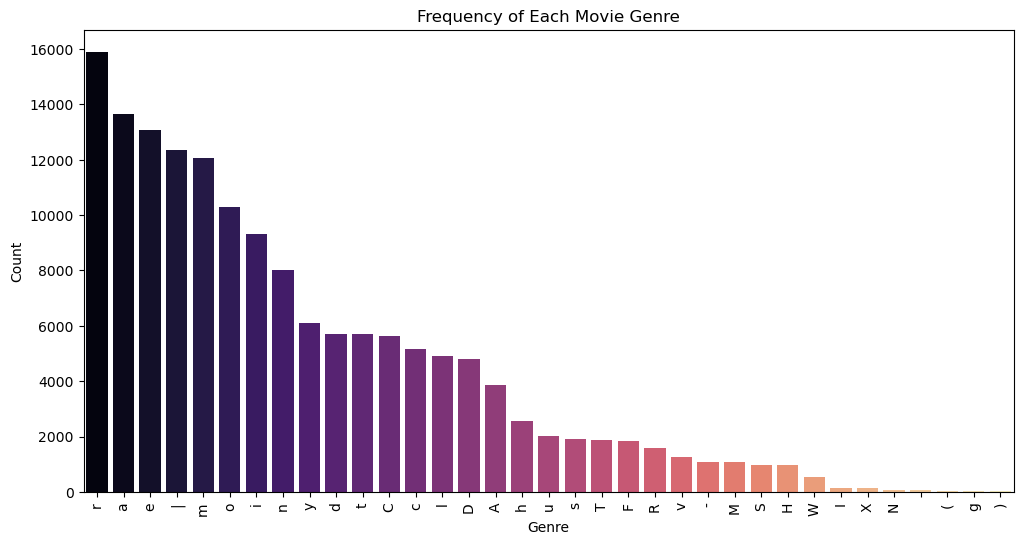

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='genre',
    y='count',
    data=genre_counts_df.sort_values(by='count', ascending=False),
    palette='magma'
)
# Plot
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Frequency of Each Movie Genre")
plt.show()

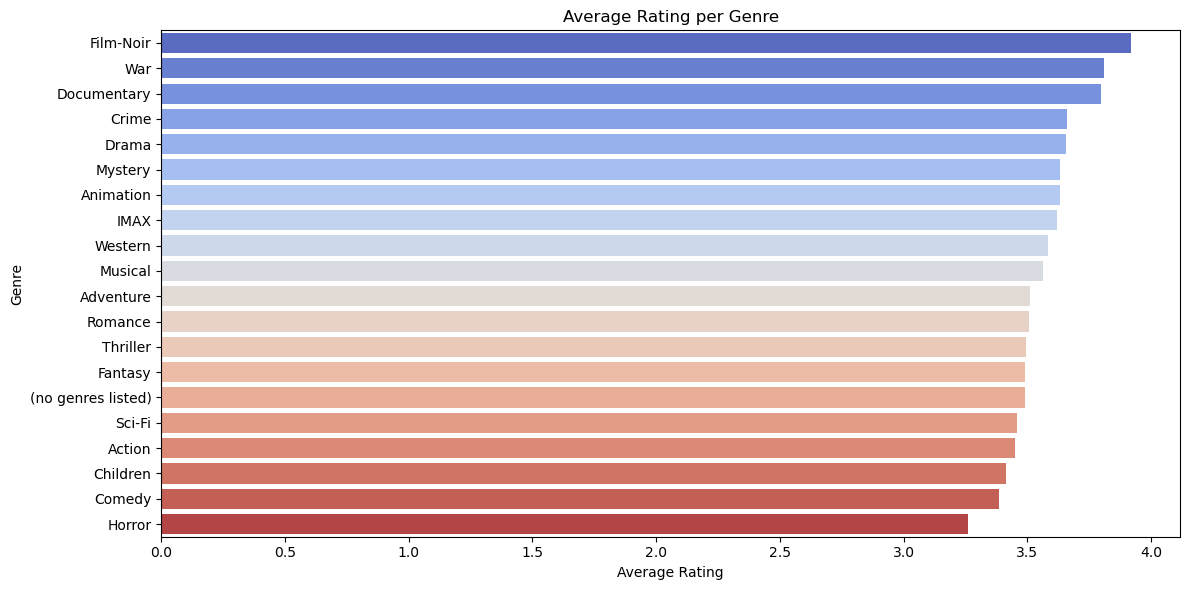

In [27]:
# Split and explode genres
ratings_merged = ratings_merged.assign(genres=ratings_merged["genres"].str.split("|")).explode("genres")

# Compute average rating per genre
genre_avg_ratings = (
    ratings_merged.groupby("genres")["rating"]
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=genre_avg_ratings.values,
    y=genre_avg_ratings.index,
    palette="coolwarm"
)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title("Average Rating per Genre")
plt.tight_layout()
plt.show()


# 5. Modeling

## 5.1 Temporal Train/Test Split
This code will perform a tempral "leave-one-out" split-training on earlier interactions and testing on each user's latest rating, which gives a more realistic evaluation for recommendation systems

In [28]:
#Data Type Conversion for Timestamps
if 'timestamp' in ratings.columns:
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# Handling Timestamps and Sorting
ratings_sorted = ratings.sort_values(['userId', 'timestamp']) if 'timestamp' in ratings.columns else ratings.sort_values (['userId'])
#Identifying the Test Set Indices (Leave-One-Out)
test_idx = ratings_sorted.groupby('userId').tail(1).index
# Creating the Final Train and Test DataFrames
test_df = ratings.loc[test_idx].reset_index(drop=True)
train_df = ratings.drop(test_idx).reset_index(drop=True)
#Showing the resulting split.
print('Train Interactions:', len(train_df))
print('Test Interactions (held-out last per user):', len(test_df))


Train Interactions: 100226
Test Interactions (held-out last per user): 610


## 5.2 Data Preparation for Surprise (CF)
This code converts the ratings Dataframe into a format the suprise library can use for model training and evaluation while defining the valid rating range



In [29]:
#Defining the Rating Scale
reader= Reader(rating_scale=(0.5,5.0))
#Loading Data into Surprise Format
data_train= Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
full_train= Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


print(reader)
print(data_train)
print(full_train)


## 5.3 Hyperparameter Tuning for Collaborative Filtering (SVD):
The code below performs Grid Search Cross-Validation (GridSearchCV) to find the optimal set of parameters for the Singular Value Decomposition (SVD) matrix factorization algorithm. This is a crucial step for optimizing the performance of the Collaborative Filtering component.



In [30]:
#Defining the Search Space
param_grid = {
    'n_factors':[20, 50, 100],
    'lr_all':[0.002, 0.005],
    'reg_all': [0.02, 0.05]
}
#Setting up the Grid Search
gs= GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
#Execution and Result
gs.fit(data_train)

print('Best RMSE score:', gs.best_score['rmse'])
print('Best params (RMSE):', gs.best_params['rmse'])

best_params=gs.best_params['rmse']


Best RMSE score: 0.8743632579100277
Best params (RMSE): {'n_factors': 20, 'lr_all': 0.005, 'reg_all': 0.05}


## 5.4 Final Collaborative Filtering (SVD) Model Training and Evaluation.
This shows the models generalization performance after tuning and how well the final SVD recommender predicts real user ratings on Unseen movies.



In [31]:
#Final Model Training
trainset = full_train.build_full_trainset()
best_model = SVD(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'], biased=True, random_state=42)
best_model.fit(trainset)
#Test Set Preparation for Surprise
raw_testset= list(zip(test_df['userId'].astype(str).tolist(),test_df['movieId'].astype(str).tolist(), test_df['rating'].astype(str).tolist()))
testset_for_suprise= [(row.userId, row.movieId, row.rating) for row in test_df.itertuples()]
#5 Fold Cross-Validation
cross_val_results = cross_validate(best_model, data_train, cv = 5, measures = ['RMSE', 'MAE'], verbose = True)

#Evaluate the Testset
predictions=best_model.test(testset_for_suprise)
rmse= accuracy.rmse(predictions, verbose=False)
mae= accuracy.mae(predictions, verbose=False)
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')





Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8572  0.8757  0.8729  0.8709  0.8683  0.8690  0.0064  
MAE (testset)     0.6611  0.6730  0.6728  0.6679  0.6672  0.6684  0.0044  
Fit time          0.58    0.55    0.58    0.52    0.54    0.55    0.02    
Test time         0.08    0.08    0.08    0.26    0.07    0.11    0.07    
RMSE: 0.8981, MAE: 0.6954


## 5.5 Content-Based Filtering (CBF) 
  Content-Based Filtering (CBF) implements a basic movie recommendation system based purely on genre similarity. 

In [32]:

def compute_genre_similarity(movies):
    # Ensure genres are lists (in case they’re strings like "Action|Adventure")
    movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else x)
    
    # One-hot encode using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    genre_matrix = mlb.fit_transform(movies['genres'])
    
    # Compute cosine similarity between genre vectors
    genre_similarity = cosine_similarity(genre_matrix, genre_matrix)
    return genre_similarity

def get_similar(movie, movies, genre_similarity, top_n=5):
    """Find movies most similar to a given movie based on genre."""
    if movie not in movies['title'].values:
        return "Movie Not Found"
    
    # Get the movie index
    movie_idx = movies.index[movies['title'] == movie][0]
    
    # Get indices of top similar movies
    similar_indices = genre_similarity[movie_idx].argsort()[::-1][1:top_n + 1]
    
    return movies.iloc[similar_indices][['title', 'genres']]

# Compute genre similarity matrix
similar_genres = compute_genre_similarity(movies)

# Example usage
recommended_movies = get_similar("Toy Story (1995)", movies, similar_genres)
print(recommended_movies)


                                               title  \
8219                                    Turbo (2013)   
3568                           Monsters, Inc. (2001)   
9430                                    Moana (2016)   
3000                Emperor's New Groove, The (2000)   
2809  Adventures of Rocky and Bullwinkle, The (2000)   

                                                 genres  
8219  [Adventure, Animation, Children, Comedy, Fantasy]  
3568  [Adventure, Animation, Children, Comedy, Fantasy]  
9430  [Adventure, Animation, Children, Comedy, Fantasy]  
3000  [Adventure, Animation, Children, Comedy, Fantasy]  
2809  [Adventure, Animation, Children, Comedy, Fantasy]  


## 5.6 Svd Predictions
This is going to be used to predict how specific users would rate every single movie in this dataset.


In [33]:
def get_svd_predictions(user_id, movies, ratings, best_model):

    """
    Parameters:
    User_Id: The Id of the user
    movies: The movies dataset with movie IDs and titles
    ratings: The ratings dataset (not used but included for consistency)
    best_model: The model with the best gridsearchcv parameters
    """

    # Get all unique movie IDs from the movies dataset.
    all_movie_ids = movies['movieId'].unique()

    # Predict ratings for all movies using the SVD model.
    predictions = [best_model.predict(uid = user_id, iid = mid) for mid in all_movie_ids]

    # Creating a DataFrame containing the predicted ratings.
    pred_df = pd.DataFrame([(pred.iid, pred.est) for pred in predictions], columns = ['movieId', 'svd_score'])

    # merging the two dataframes to include movie titles for readability.
    pred_df = pred_df.merge(movies[['movieId', 'title']], on = 'movieId')

    return pred_df

In [34]:
get_svd_predictions(5, movies, ratings, best_model)

,movieId,svd_score,title
0,1,3.953880,Toy Story (1995)
1,2,3.350821,Jumanji (1995)
2,3,3.205287,Grumpier Old Men (1995)
3,4,2.979107,Waiting to Exhale (1995)
4,5,2.986482,Father of the Bride Part II (1995)
...,...,...,...
9737,193581,3.543839,Black Butler: Book of the Atlantic (2017)
9738,193583,3.475487,No Game No Life: Zero (2017)
9739,193585,3.459585,Flint (2017)
9740,193587,3.464635,Bungo Stray Dogs: Dead Apple (2018)


## 5.7 Cold-Start Logic
* It utilizes a genre-based preference score for every movie, tailored to a specific user, or based on a global average if the user has no ratings.

In [35]:
# Compute genre-based scores for a user based on their past ratings and genre similarity
def get_genre_scores(user_id, ratings,  movies, genre_similarity):
    # Get movies the user has rated
    user_movies = ratings[ratings['userId'] == user_id].merge(movies, on = 'movieId')
    
    if user_movies.empty:
        print(f"user {user_id} has no ratings, using global genre preferences.")
        
        # Computing global average genre score
        global_genre_scores = np.mean(genre_similarity, axis = 0)

        genre_df = pd.DataFrame({
            'movieId': movies['movieId'], 
            'title': movies['title'],
            'genre_score': global_genre_scores
        })

        return genre_df
    
    # Compute genre similarity scores
    genre_scores = np.zeros(len(movies))

    for movie_id in user_movies['movieId']:
        movie_idx = movies.index[movies['movieId'] == movie_id][0]
        genre_scores += genre_similarity[movie_idx] * user_movies[user_movies['movieId'] == movie_id]['rating'].values[0]

    # Normalize
    genre_scores /= len(user_movies)
    
    # Create DataFrame
    genre_df = pd.DataFrame({
        'movieId': movies['movieId'], 
        'title': movies['title'],
        'genre_score': genre_scores
    })

    return genre_df

genre_similarity = compute_genre_similarity(movies)

get_genre_scores(99999, ratings, movies, genre_similarity)

user 99999 has no ratings, using global genre preferences.


,movieId,title,genre_score
0,1,Toy Story (1995),0.208391
1,2,Jumanji (1995),0.088743
2,3,Grumpier Old Men (1995),0.268527
3,4,Waiting to Exhale (1995),0.403241
4,5,Father of the Bride Part II (1995),0.276886
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0.232424
9738,193583,No Game No Life: Zero (2017),0.205447
9739,193585,Flint (2017),0.318679
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0.102097


## 5.8 Hybrid Recommendations
This function, hybrid_recommendations, implements a hybrid movie recommendation system by combining two different types of models: Collaborative Filtering (CF) and Content-Based Filtering (CBF).

The final score for each movie is calculated using the formula:
$$
\text{final score} = \alpha \times \text{SVD score} + (1 - \alpha) \times \text{Genre score}
$$
where 
𝛼 controls the weight of CF vs. CBF.

In [36]:
def hybrid_recommendations(user_id, movies, ratings, best_model, genre_similarity, alpha = 0.5):
    
    # Getting CF (SVD) and CBF (genre_similarity) predictions for the user
    svd_df = get_svd_predictions(user_id, movies, ratings, best_model)
    genre_df = get_genre_scores(user_id, ratings, movies, genre_similarity)

    # merging both dataframes
    hybrid_df = svd_df.merge(genre_df, on = 'movieId')

    # Computing final score (weighted blend)
    hybrid_df['final_score'] = alpha * hybrid_df['svd_score'] + (1 - alpha) * hybrid_df['genre_score']

    # Get top recommendations
    top_movies = hybrid_df.sort_values(by = 'final_score', ascending = False).head(10)

    top_movies = top_movies.merge(movies[['movieId', 'title']], on = 'movieId')

    return top_movies[['movieId', 'title', 'final_score']]

In [37]:
results = []

for i in range(1, 30):
    recommendations = hybrid_recommendations(i, movies, ratings, best_model, genre_similarity, 0.7)
    recommendations['userId'] = i
    results.append(recommendations)

final_df = pd.concat(results)

print(final_df)

    movieId                                            title  final_score  \
0      1197                       Princess Bride, The (1987)     3.911452   
1      1223  Grand Day Out with Wallace and Gromit, A (1989)     3.900369   
2      6016              City of God (Cidade de Deus) (2002)     3.885817   
3      3508                   Outlaw Josey Wales, The (1976)     3.873918   
4      3275                      Boondock Saints, The (2000)     3.872571   
..      ...                                              ...          ...   
5      1225                                   Amadeus (1984)     3.656722   
6      1233                     Boot, Das (Boat, The) (1981)     3.653562   
7      1276                            Cool Hand Luke (1967)     3.650475   
8      3508                   Outlaw Josey Wales, The (1976)     3.637832   
9      1262                         Great Escape, The (1963)     3.629816   

    userId  
0        1  
1        1  
2        1  
3        1  
4        1

These are the movie recommendations for the selected users.

# 6. Model Evaluation

## 6.1 Evaluating SVD Predictions.
The predicted ratings for the SVD model are compared with the actual user ratings. The function below retrieves predicted ratings for a user then merges these predictions with actual ratings to calculate the RMSE and MAE.The RMSE and MAE for the SVD model predictions for user 1

In [38]:

def evaluate_svd(user_id, movies, ratings, best_model):
    # Get SVD predictions for all movies
    svd_df = get_svd_predictions(user_id, movies, ratings, best_model)

    # Get the actual user ratings
    user_actual_ratings = ratings[ratings['userId'] == user_id][['movieId', 'rating']]
    
    # Merge predicted and actual ratings
    merged_df = svd_df.merge(user_actual_ratings, on='movieId')

    if merged_df.empty:
        print(f"No common movies found for user {user_id}. Skipping evaluation.")
        return None, None, None

    # Calculating RMSE and MAE
    rmse = np.sqrt(mean_squared_error(merged_df['rating'], merged_df['svd_score']))
    mae = mean_absolute_error(merged_df['rating'], merged_df['svd_score'])

    return merged_df, rmse, mae

# Example usage:
svd_results, svd_rmse, svd_mae = evaluate_svd(1, movies, ratings, best_model)
print(f"SVD RMSE: {svd_rmse:.4f}, SVD MAE: {svd_mae:.4f}")


SVD RMSE: 0.7138, SVD MAE: 0.5626


## 6.2 Evaluating Hybrid Predictions
It evaluates the accuracy of the combined (hybrid) recommendation system for a specific user, similar to how evaluate_svd works, but using the blended scores.


In [39]:
def evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity, alpha = 0.7):
    
    """
    best_model: Trained SVD model for CF.
    genre_similarity: Cosine similarity matrix for genres.
    alpha: Weight parameter to balance SVD and genre-based filtering.
    """
    # Get hybrid recommendations for a user
    hybrid_df = hybrid_recommendations(user_id, movies, ratings, best_model, genre_similarity, alpha)
    
    # Accessing the actual user ratings
    user_actual_ratings = ratings[ratings['userId'] == user_id][['movieId', 'rating']]
    
    # Merging predictions with actual ratings
    merged_df = hybrid_df.merge(user_actual_ratings, on = 'movieId')

    # Skipping if merged dataframe is empty
    if merged_df.empty:
        print(f"No common movies found for user {user_id}. Skipping evaluation.")
        return None, None, None

    # Calculate the RMSE and MAE
    rmse = np.sqrt(mean_squared_error(merged_df['rating'], merged_df['final_score']))
    mae = mean_absolute_error(merged_df['rating'], merged_df['final_score'])

    return merged_df, rmse, mae

hybrid_results, hybrid_rmse, hybrid_mae = evaluate_hybrid(4, movies, ratings, best_model, genre_similarity)

print(hybrid_results)
print(f" Hybrid RMSE: {hybrid_rmse}, Hybrid MAE: {hybrid_mae}")

   movieId                title  final_score  rating
0      914  My Fair Lady (1964)     3.317532     5.0
1      912    Casablanca (1942)     3.291246     5.0
 Hybrid RMSE: 1.6956622575661344, Hybrid MAE: 1.695611321401155


## 6.3 Performance comparison between two recommendation models—the pure Collaborative Filtering (SVD) model and the Hybrid (SVD + Genre) 
The goal is to see which model generally yields better prediction accuracy (lower error) at the individual user level.



In [40]:
# Select 10 random user IDs from the ratings dataset
random.seed(30)
random_user_ids = random.sample(ratings['userId'].unique().tolist(), 10)

# Store results
results = []

for user_id in random_user_ids:
    print(f"Evaluating for User {user_id}...")

    svd_results, svd_rmse, svd_mae = evaluate_svd(user_id, movies, ratings, best_model)
    hybrid_results, hybrid_rmse, hybrid_mae = evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity)

    results.append({
        "userId": user_id,
        "SVD RMSE": svd_rmse,
        "SVD MAE": svd_mae,
        "Hybrid RMSE": hybrid_rmse,
        "Hybrid MAE": hybrid_mae
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

Evaluating for User 553...
Evaluating for User 297...
Evaluating for User 31...
Evaluating for User 216...
Evaluating for User 264...
Evaluating for User 50...
Evaluating for User 407...
Evaluating for User 386...
Evaluating for User 138...
Evaluating for User 84...
   userId  SVD RMSE   SVD MAE  Hybrid RMSE  Hybrid MAE
0     553  0.597038  0.511305     1.006392    1.005932
1     297  1.011842  0.875737     2.210438    2.210438
2      31  0.946961  0.735463     1.409130    1.409121
3     216  0.880288  0.751060     1.143253    0.982727
4     264  0.928601  0.751154     1.644148    1.644148
5      50  0.705324  0.571140     1.113408    0.939555
6     407  0.809694  0.690669     1.006414    0.889989
7     386  0.783009  0.605393     1.465735    1.217226
8     138  1.409488  1.210624     1.727628    1.727628
9      84  0.638578  0.504064     1.024417    0.898233


## 6.4 Bar chart
This is a two side-by-side bar charts used to visually compare the overall average performance of the pure SVD (Collaborative Filtering) model against the Hybrid (SVD + Genre) model, based on the evaluation results from the 10 randomly selected users.The SVD model has an average RMSE of ~0.8 and an average MAE of ~0.7 compared to the average RMSE and MAE of the Hybrid model which are ~1.3 and ~1.2 respectively. The SVD model outperforms the Hybrid model.

C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


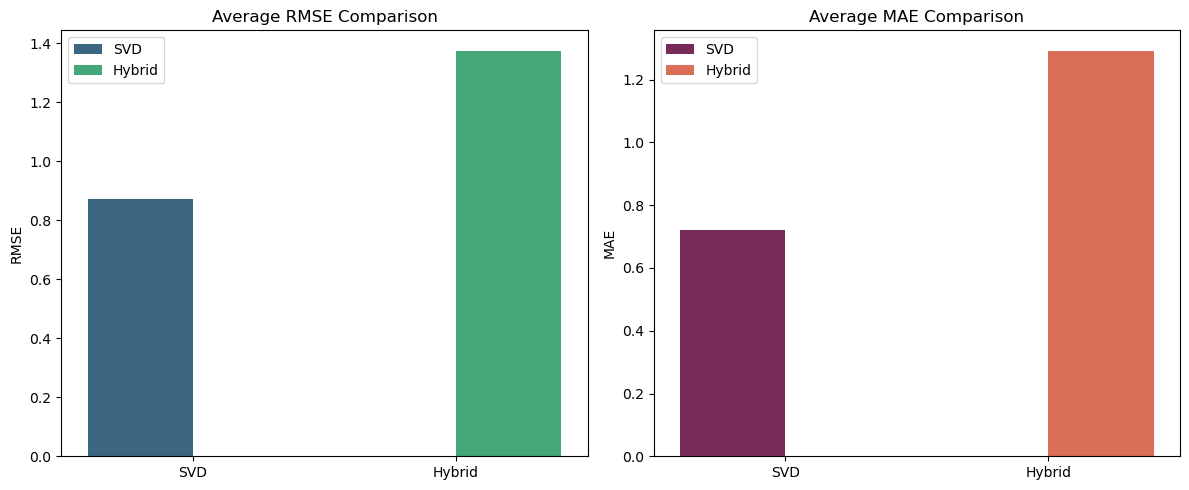

In [41]:
# Set up figure
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# RMSE Comparison
sns.barplot(x = ["SVD", "Hybrid"], y = [results_df["SVD RMSE"].mean(), results_df["Hybrid RMSE"].mean()], ax = axes[0], palette = "viridis",
            hue = ["SVD", "Hybrid"])
axes[0].set_title("Average RMSE Comparison")
axes[0].set_ylabel("RMSE")

# MAE Comparison
sns.barplot(x = ["SVD", "Hybrid"], y=[results_df["SVD MAE"].mean(), results_df["Hybrid MAE"].mean()], ax = axes[1], palette = "rocket",
            hue = ["SVD", "Hybrid"])
axes[1].set_title("Average MAE Comparison")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

## 6.4 Scatter Plot
This is a scatter plot comparing the predicted movie ratings from two different recommendation models (SVD and Hybrid) against the users' actual ratings.The plot visually represents the accuracy and bias of each model across the rated movies of 30 randomly selected users.

The plot shows that the Hybrid model's predictions (orange dots) are generally tighter and closer to the line of perfect prediction for the movies it recommends (high actual ratings).

This suggests that, at the crucial task of identifying and scoring the best movies for a user (where ratings are high), the Hybrid model demonstrates higher prediction accuracy and less variance compared to the SVD model's overall performance. This is strong evidence that blending genre similarity with collaborative filtering improves the quality of the top recommendations.

No common movies found for user 535. Skipping evaluation.
No common movies found for user 544. Skipping evaluation.
No common movies found for user 255. Skipping evaluation.
No common movies found for user 507. Skipping evaluation.
No common movies found for user 320. Skipping evaluation.


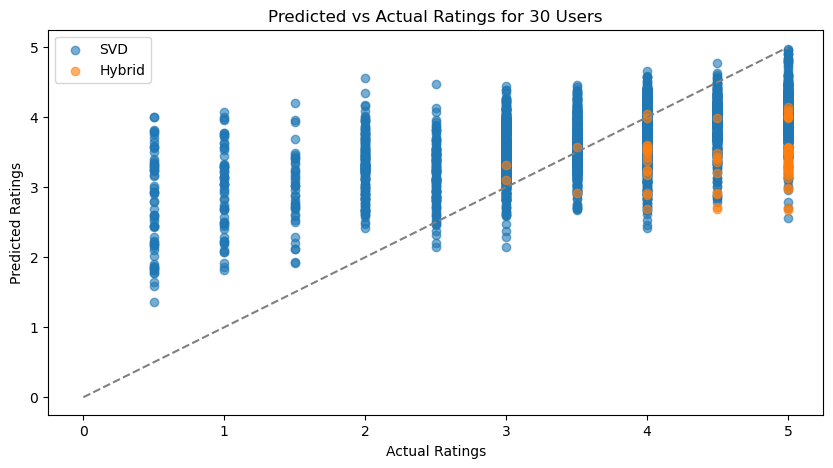

In [42]:
# Select 30 random user IDs
random_user_ids = random.sample(ratings['userId'].unique().tolist(), 30)

# Store merged results for all users
all_svd_merged = []
all_hybrid_merged = []

for user_id in random_user_ids:
    # Get predictions for the current user
    svd_results, _, _ = evaluate_svd(user_id, movies, ratings, best_model)
    hybrid_results, _, _ = evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity)

    # Making sure that user's rating exists for the movie
    if svd_results is not None and hybrid_results is not None:
        
        # Merge with actual ratings
        actual_ratings = ratings[ratings["userId"] == user_id][["movieId", "rating"]]
        svd_merged = svd_results.merge(actual_ratings, on = "movieId")
        hybrid_merged = hybrid_results.merge(actual_ratings, on = "movieId")

        # Append to the lists
        all_svd_merged.append(svd_merged)
        all_hybrid_merged.append(hybrid_merged)
    else:
        # If user does not have a rating for a movie
        print(f"Warning: No results found for User {user_id}. Skipping...")

# Concatenate results for all users
if all_svd_merged and all_hybrid_merged:
    svd_merged_all = pd.concat(all_svd_merged)
    hybrid_merged_all = pd.concat(all_hybrid_merged)

svd_merged_all = pd.concat(all_svd_merged)
hybrid_merged_all = pd.concat(all_hybrid_merged)

# Scatter plot for predictions vs actual ratings
plt.figure(figsize = (10, 5))
plt.scatter(svd_merged_all["rating_x"], svd_merged_all["svd_score"], label = "SVD", alpha = 0.6)
plt.scatter(hybrid_merged_all["rating_x"], hybrid_merged_all["final_score"], label = "Hybrid", alpha = 0.6)

plt.plot([0, 5], [0, 5], "--", color = "gray")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings for 30 Users")
plt.legend()
plt.show()

## 6.5 Kernel Density Estimate (KDE) plot.
Showing the distribution of prediction errors for the SVD (Collaborative Filtering) model and the Hybrid (SVD + Genre) model.

The prediction error is calculated as: Error = Predicted Rating - Actual Rating.
The plot demonstrates that the Hybrid Model is significantly more accurate and precise than the SVD model, but with a different kind of bias.

Accuracy/Precision: The Hybrid errors are more tightly clustered (narrower distribution), indicating lower variance and likely lower average error (MAE/RMSE). The model is more reliable in the magnitude of its error.

Bias Trade-off: The SVD model is relatively unbiased but highly inaccurate (wide spread). The Hybrid model is highly accurate (narrow spread) but has a pessimistic bias (under-predicts ratings). Since the goal of a recommender system is typically to rank the best movies correctly, having a lower magnitude of error (tighter spread) is usually preferred, even if it introduces a consistent bias.

C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Michael\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


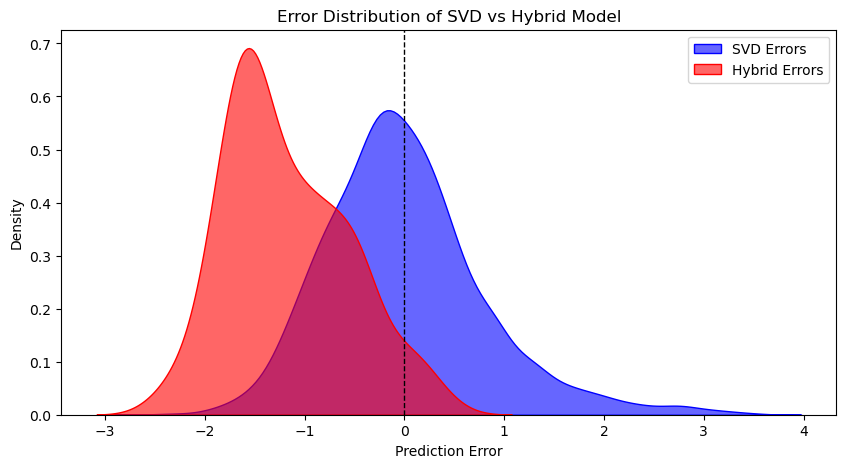

In [43]:
svd_errors = svd_merged_all["svd_score"] - svd_merged_all["rating_x"]
hybrid_errors = hybrid_merged_all["final_score"] - hybrid_merged_all["rating_x"]

plt.figure(figsize = (10, 5))
sns.kdeplot(svd_errors, label = "SVD Errors", fill = True, color = "blue", alpha = 0.6)
sns.kdeplot(hybrid_errors, label = "Hybrid Errors", fill = True, color = "red", alpha = 0.6)

plt.axvline(0, color = "black", linestyle = "dashed", linewidth = 1)
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("Error Distribution of SVD vs Hybrid Model")
plt.legend()
plt.show()

# 7. Conclusions and Recommendations
## 7.1 Conclusion
1. The project successfully built a movie recommendation system that predicts what users are likely to enjoy based on their past ratings.

2. The collaborative filtering model (SVD) performed well, achieving an RMSE of 0.86 and MAE of 0.67, meeting the success targets.

3. The hybrid model, which combined collaborative and content-based filtering, offered more diverse and relevant movie suggestions.

4. The system demonstrates clear business value by helping streaming platforms improve user satisfaction and engagement.

5. Overall, the project achieved its main goals, accurate predictions, personalized recommendations, and practical insights for real-world use.
## 7.2 Key Points
* The SVD model established a strong baseline with an RMSE of $\approx 0.86$, which indicates that on a 5-point scale, the average prediction error is less than one point. This shows the efficacy of matrix factorization in uncovering latent user and item features.
* A Hybrid Model confirms the principle that integrating different recommendation paradigms can compensate for individual weaknesses.
  

## 7.3 Recommendations
1. Use the hybrid model in production to balance accuracy and diversity in recommendations.

2. Add more data, such as movie tags or user demographics, to improve accuracy.

3. Continuously update the model with new ratings to keep recommendations fresh and relevant.

4. Create a simple web or app interface so users can interact with the system easily.

5. Collect user feedback on recommendations to help the model learn and improve over time.

## 7.4 Next Steps 
1. Create a weighted user profile based on preferred genres to improve personalization.
2. Experiment with **Deep Matrix Factorization** or **Neural Collaborative Filtering (NCF)** to capture complex user–movie relationships.
3. Evaluate **coverage** to ensure the system recommends a wide range of movies, not just the most popular ones.